In [26]:
# ========================================
# 01_data_preparation.ipynb
# 数据下载和探索
# ========================================

# ----- Cell 1: 挂载Google Drive -----
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:

# ----- Cell 2: 设置工作目录和创建文件夹 -----
import os

PROJECT_ROOT = '/content/drive/MyDrive/SHBT 261/Mini_Project_2'

# 切换到项目目录
os.chdir(PROJECT_ROOT)
print(f"当前工作目录: {os.getcwd()}")

# 创建必要的文件夹
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
print("✓ 文件夹结构创建完成")


当前工作目录: /content/drive/MyDrive/SHBT 261/Mini_Project_2
✓ 文件夹结构创建完成


In [28]:
# ----- Cell 3: Install dependencies -----
!pip install -q kagglehub
!pip install -q torch torchvision
!pip install -q matplotlib numpy tqdm

print("✓ Dependencies installed")


✓ Dependencies installed


In [29]:
# ----- Cell 4: Download dataset using kagglehub (no copy to Drive) -----
import kagglehub
import os

print("Downloading Pascal VOC 2007 dataset...")
dataset_path = kagglehub.dataset_download("zaraks/pascal-voc-2007")
print(f"✓ Dataset downloaded to: {dataset_path}")

# Explore the downloaded structure
print("\nDataset structure:")
!ls -lh {dataset_path}


Using Colab cache for faster access to the 'pascal-voc-2007' dataset.
✓ Dataset downloaded to: /kaggle/input/pascal-voc-2007

Dataset structure:
total 0
drwxr-sr-x 3 1000 1000 0 Nov 11 19:02 pascal_voc
drwxr-sr-x 3 1000 1000 0 Nov 11 19:01 PASCAL_VOC
drwxr-sr-x 3 1000 1000 0 Nov 11 19:02 voctest_06-nov-2007
drwxr-sr-x 3 1000 1000 0 Nov 11 19:01 VOCtest_06-Nov-2007
drwxr-sr-x 3 1000 1000 0 Nov 11 19:03 voctrainval_06-nov-2007
drwxr-sr-x 3 1000 1000 0 Nov 11 19:02 VOCtrainval_06-Nov-2007


In [30]:
# ----- Cell 5: Find TRAINVAL dataset with CORRECT path structure -----
import os

# Find the TRAINVAL dataset
trainval_candidates = [
    'VOCtrainval_06-Nov-2007',
    'voctrainval_06-nov-2007',
    'VOCtrainval_06-nov-2007'
]

VOC_ROOT = None
for candidate in trainval_candidates:
    # VOC_ROOT should point to the folder CONTAINING VOCdevkit
    # NOT the VOCdevkit folder itself
    candidate_path = os.path.join(dataset_path, candidate)
    voc2007_path = os.path.join(candidate_path, 'VOCdevkit', 'VOC2007')

    if os.path.exists(voc2007_path):
        VOC_ROOT = candidate_path  # This is the key change!
        VOC2007_PATH = voc2007_path
        print(f"✓ Found trainval dataset")
        print(f"  VOC_ROOT: {VOC_ROOT}")
        print(f"  VOC2007_PATH: {VOC2007_PATH}")
        break

if VOC_ROOT is None:
    print("✗ ERROR: Could not find trainval dataset!")
else:
    print("\nVOC2007 contents:")
    !ls -lh {VOC2007_PATH}

    # Verify segmentation files
    seg_class_path = os.path.join(VOC2007_PATH, 'SegmentationClass')
    if os.path.exists(seg_class_path):
        seg_count = len(os.listdir(seg_class_path))
        print(f"\nSegmentationClass files: {seg_count}")

✓ Found trainval dataset
  VOC_ROOT: /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007
  VOC2007_PATH: /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007

VOC2007 contents:
total 0
drwxr-sr-x 2 1000 1000 0 Nov 11 19:02 Annotations
drwxr-sr-x 5 1000 1000 0 Nov 11 19:02 ImageSets
drwxr-sr-x 2 1000 1000 0 Nov 11 19:02 JPEGImages
drwxr-sr-x 2 1000 1000 0 Nov 11 19:02 SegmentationClass
drwxr-sr-x 2 1000 1000 0 Nov 11 19:02 SegmentationObject

SegmentationClass files: 422


In [31]:
# ----- Cell 6: Save path for future use (REPLACE OLD CELL 6) -----
# Save the path to Drive
with open(f'{PROJECT_ROOT}/voc_data_path.txt', 'w') as f:
    f.write(VOC_ROOT)

print(f"✓ VOC path saved to: {PROJECT_ROOT}/voc_data_path.txt")
print(f"\nUse this in training notebooks:")
print(f"VOC_ROOT = '{VOC_ROOT}'")


✓ VOC path saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/voc_data_path.txt

Use this in training notebooks:
VOC_ROOT = '/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007'


In [32]:
# ----- Cell 7: Verify dataset structure -----
import os

# Check essential folders
essential_folders = ['JPEGImages', 'SegmentationClass', 'ImageSets', 'Annotations']

print("Verifying dataset structure:")
print("=" * 60)

for folder in essential_folders:
    folder_path = os.path.join(VOC2007_PATH, folder)
    if os.path.exists(folder_path):
        file_count = len(os.listdir(folder_path))
        print(f"✓ {folder:20s}: {file_count:5d} files")
    else:
        print(f"✗ {folder:20s}: NOT FOUND")

print("=" * 60)


Verifying dataset structure:
✓ JPEGImages          :  5011 files
✓ SegmentationClass   :   422 files
✓ ImageSets           :     3 files
✓ Annotations         :  5011 files


In [33]:
# ----- Cell 8: Define VOC classes and data transforms -----
import torch
from torchvision import transforms

# Define 21 classes (20 objects + background)
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

NUM_CLASSES = len(VOC_CLASSES)
print(f"Number of classes: {NUM_CLASSES}")
print("\nClass mapping:")
for idx, name in enumerate(VOC_CLASSES):
    print(f"  {idx:2d}: {name}")

# Define transforms
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_target = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.PILToTensor()
])

print("\n✓ Transforms defined")


Number of classes: 21

Class mapping:
   0: background
   1: aeroplane
   2: bicycle
   3: bird
   4: boat
   5: bottle
   6: bus
   7: car
   8: cat
   9: chair
  10: cow
  11: diningtable
  12: dog
  13: horse
  14: motorbike
  15: person
  16: pottedplant
  17: sheep
  18: sofa
  19: train
  20: tvmonitor

✓ Transforms defined


In [34]:
# ----- Cell 9: Load datasets -----
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation

# Load train and validation datasets
print("Loading datasets...")

train_dataset = VOCSegmentation(
    root=VOC_ROOT,
    year="2007",
    image_set="train",
    download=False,
    transform=transform_img,
    target_transform=transform_target
)

val_dataset = VOCSegmentation(
    root=VOC_ROOT,
    year="2007",
    image_set="val",
    download=False,
    transform=transform_img,
    target_transform=transform_target
)

print(f"✓ Train samples: {len(train_dataset)}")
print(f"✓ Validation samples: {len(val_dataset)}")


Loading datasets...
✓ Train samples: 209
✓ Validation samples: 213


In [35]:
# ----- Cell: Debug - Check VOC_ROOT -----
print(f"Current VOC_ROOT: {VOC_ROOT}")
print(f"Expected voc_root by torchvision: {os.path.join(VOC_ROOT, 'VOC2007')}")
print(f"\nDoes VOC2007 exist? {os.path.exists(os.path.join(VOC_ROOT, 'VOC2007'))}")

# List what's in VOC_ROOT
print(f"\nContents of VOC_ROOT:")
!ls -lh {VOC_ROOT}

Current VOC_ROOT: /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007
Expected voc_root by torchvision: /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOC2007

Does VOC2007 exist? False

Contents of VOC_ROOT:
total 0
drwxr-sr-x 3 1000 1000 0 Nov 11 19:02 VOCdevkit


In [36]:
# ----- Cell 10: Create DataLoaders -----
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

# Test loading a batch
images, masks = next(iter(train_loader))
print(f"✓ DataLoaders created")
print(f"  Image batch shape: {images.shape}")  # (4, 3, 256, 256)
print(f"  Mask batch shape: {masks.shape}")    # (4, 1, 256, 256)

✓ DataLoaders created
  Image batch shape: torch.Size([4, 3, 256, 256])
  Mask batch shape: torch.Size([4, 1, 256, 256])


In [37]:
# ----- Cell 11: Visualization function -----
import matplotlib.pyplot as plt
import numpy as np

def show_sample(img, mask, save_path=None, title="Sample"):
    """
    Visualize one image and its segmentation mask

    Args:
        img: Tensor of shape (3, H, W)
        mask: Tensor of shape (1, H, W)
        save_path: Optional path to save the figure
        title: Figure title
    """
    # Convert tensors to numpy
    img = img.permute(1, 2, 0).numpy()
    mask = mask.squeeze().numpy().copy()

    # Clean mask (set invalid values to 0)
    mask[mask > 20] = 0

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot image
    axes[0].imshow(img)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Plot mask
    seg_map = axes[1].imshow(mask, cmap="tab20", vmin=0, vmax=20)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")

    # Add colorbar with class labels
    cbar = plt.colorbar(seg_map, ax=axes[1], ticks=range(21), fraction=0.046)
    tick_labels = [f"{i}-{VOC_CLASSES[i]}" for i in range(21)]
    cbar.ax.set_yticklabels(tick_labels, fontsize=7)

    # Overall title
    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved to: {save_path}")

    plt.show()

    # Print unique classes in mask
    unique_classes = np.unique(mask)
    class_names = [VOC_CLASSES[int(c)] for c in unique_classes if c <= 20]
    print(f"  Classes in mask: {class_names}")

print("✓ Visualization function defined")

✓ Visualization function defined


Visualizing 3 samples...

✓ Saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/sample_01.png


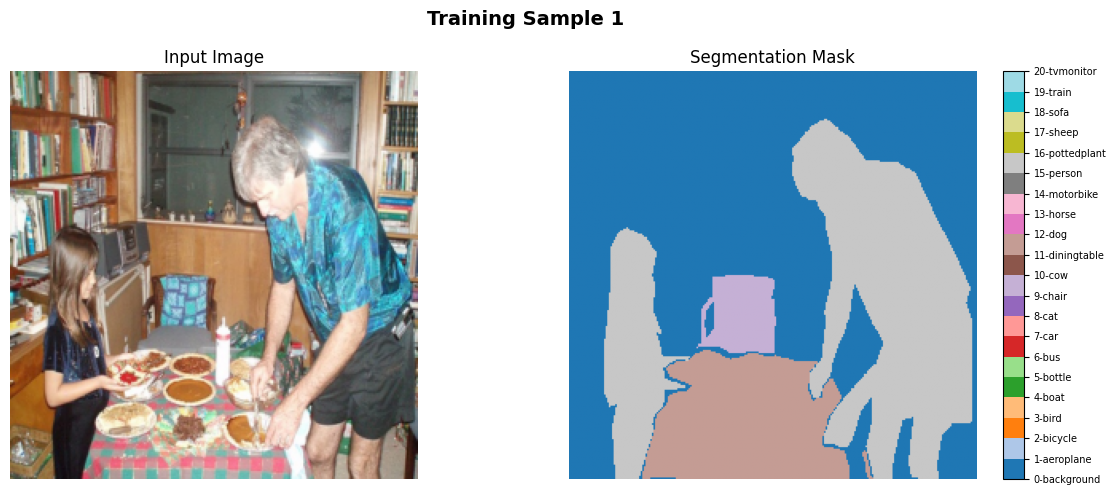

  Classes in mask: ['background', 'chair', 'diningtable', 'person']

✓ Saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/sample_02.png


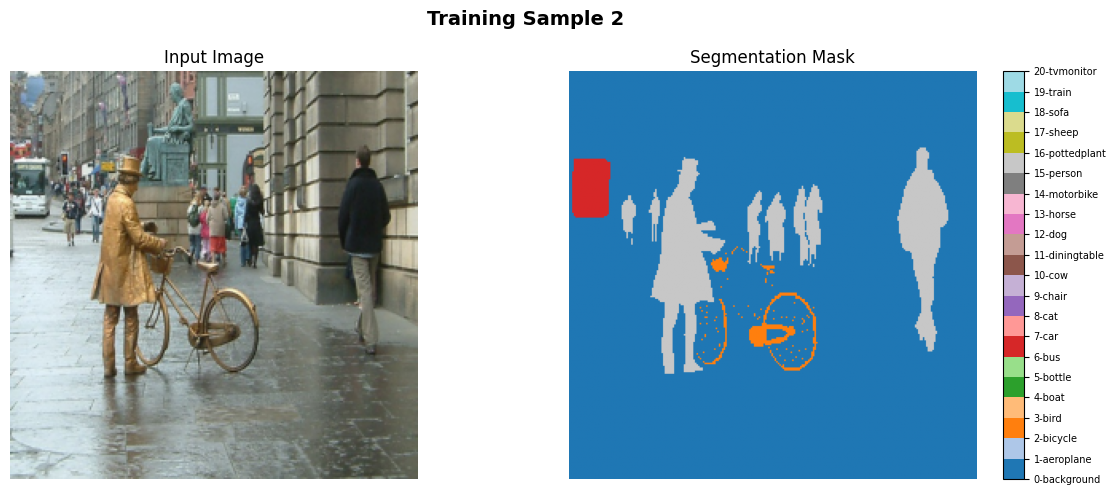

  Classes in mask: ['background', 'bicycle', 'bus', 'person']

✓ Saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/sample_03.png


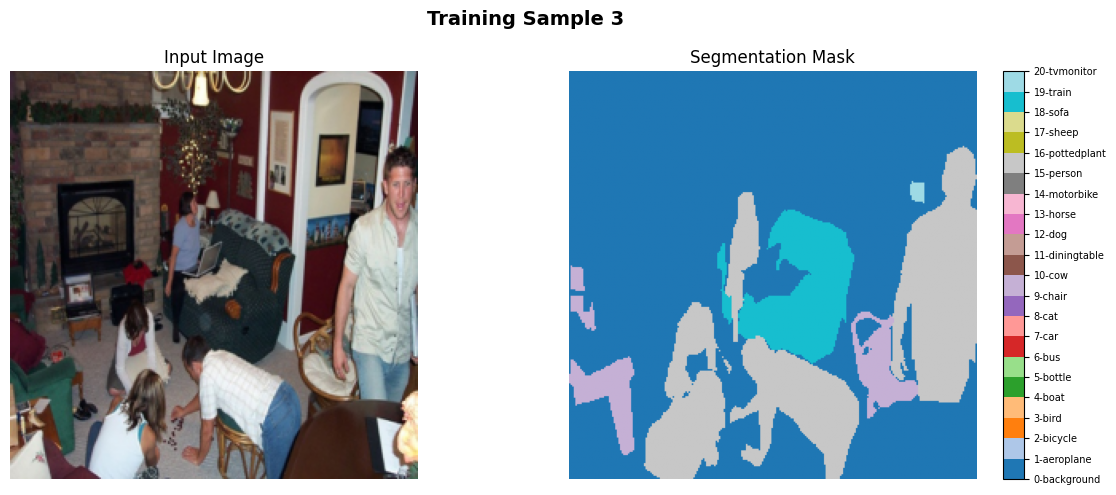

  Classes in mask: ['background', 'chair', 'person', 'sofa', 'tvmonitor']

✓ Data exploration complete!


In [38]:
# ----- Cell 12: Visualize sample images -----
num_samples = 3

print(f"Visualizing {num_samples} samples...\n")

# Get one batch
images, masks = next(iter(train_loader))

for i in range(min(num_samples, len(images))):
    save_path = f'{PROJECT_ROOT}/results/sample_{i+1:02d}.png'
    show_sample(
        images[i],
        masks[i],
        save_path=save_path,
        title=f"Training Sample {i+1}"
    )
    print()

print("=" * 60)
print("✓ Data exploration complete!")
print("=" * 60)

In [39]:
# ----- Cell 13: Summary -----
print("=" * 70)
print("DATA PREPARATION COMPLETE!")
print("=" * 70)
print(f"\n✓ Dataset location: {VOC_ROOT}")
print(f"✓ Training samples: {len(train_dataset)}")
print(f"✓ Validation samples: {len(val_dataset)}")
print(f"✓ Number of classes: {NUM_CLASSES}")
print(f"✓ Image size: 256 x 256")
print(f"✓ Sample images saved to: {PROJECT_ROOT}/results/")

print("\n" + "=" * 70)
print("NEXT STEPS:")
print("=" * 70)
print("1. ✓ Data preparation completed")
print("2. → Create 02_unet_training.ipynb")
print("3. → Create 03_deeplabv3_training.ipynb")
print("4. → Create 04_sam_training.ipynb")
print("5. → Create 05_evaluation.ipynb")
print("=" * 70)

DATA PREPARATION COMPLETE!

✓ Dataset location: /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007
✓ Training samples: 209
✓ Validation samples: 213
✓ Number of classes: 21
✓ Image size: 256 x 256
✓ Sample images saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/

NEXT STEPS:
1. ✓ Data preparation completed
2. → Create 02_unet_training.ipynb
3. → Create 03_deeplabv3_training.ipynb
4. → Create 04_sam_training.ipynb
5. → Create 05_evaluation.ipynb
